### Задача Kaggle https://www.kaggle.com/competitions/practical-ml-chocolate/data

В датасете содержится информация о более чем 1700 шоколадках. В датасете представлена информация о темном шоколаде.
#### Система рейтинга шоколада:
    5 = Elite
    4 = Premium
    3 = Satisfactory(3.0) to praiseworthy(3.75)
    2 = Disappointing
    1 = Unpleasant

Для получения рейтинга каждой шоколадки оцениваются все ее характеристики.

Ваша задача - по характеристикам шоколадки научиться предсказывать ее рейтинг без округлений (то есть если рейтинг 3.75 - хорошая модель должна предсказать 3.75).

### Импорт библиотек, загрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

import warnings

warnings.simplefilter("ignore")

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder 
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score

In [3]:
train = pd.read_csv('chocolate_train.csv')
RANDOM_STATE = 42

##### Описание данных
    - Company - компания производитель
    - Specific Bean Origin - географический регион происхождения
    - REF - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)
    - Review - дата публикации отзыва
    - Cocoa Percent - процентное содержание какао
    - Company Location - страна производитель
    - Rating - экспертный рейтинг
    - Bean Type - используемый сорт какао-бобов, если таковой имеется
    - Broad Bean Origin - географический регион происхождения какао-бобов

## 1) Обзор данных

In [4]:
train.head(1)

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela


In [5]:
train.info()# посмотрим общие сведения о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   object 
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             1254 non-null   object 
 8   Broad Bean Origin     1254 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 88.4+ KB


In [6]:
train.isnull().sum()# посмотрим пропущенные значения 

Company                 0
Specific Bean Origin    0
REF                     0
Review                  0
Cocoa Percent           0
Company Location        0
Rating                  0
Bean Type               1
Broad Bean Origin       1
dtype: int64

In [7]:
train['Bean Type'].value_counts().head(3)# пропущенных значений больше чем 1 (628)

              628
Trinitario    285
Criollo       104
Name: Bean Type, dtype: int64

In [8]:
train['Broad Bean Origin'].value_counts().head(10) # пропущенных значений больше чем 1 (55)

Venezuela             144
Ecuador               142
Peru                  122
Dominican Republic    104
Madagascar            103
                       55
Brazil                 43
Nicaragua              42
Bolivia                42
Belize                 30
Name: Broad Bean Origin, dtype: int64

<Axes: >

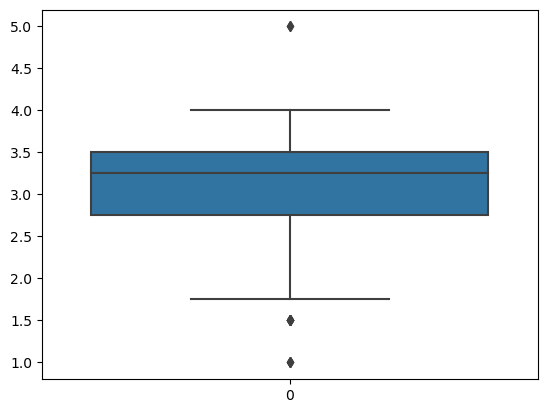

In [9]:
sns.boxplot(train['Rating'])

In [10]:
# удаление выбросов целевой переменной
train  = train.loc[(train['Rating'] > 1.5) & (train ['Rating'] < 5)]
train['Rating'].unique()

array([3.25, 3.5 , 3.  , 2.75, 3.75, 2.5 , 4.  , 2.25, 2.  , 1.75])

## 2) Заполним пропущенные значения колонки и обработаем данные

In [11]:
train['Bean Type'] = train['Bean Type'].astype("str")

In [12]:
train['Bean Type'] = train['Bean Type'].apply(lambda x: 'Missing' if len(x)<2 else x)

In [13]:
train['Broad Bean Origin'] = train['Broad Bean Origin'].astype("str")

In [14]:
train['Broad Bean Origin'] = train['Broad Bean Origin'].apply(lambda x: 'Missing' if len(x)<2 else x)

In [15]:
columns_to_split = ['Company Location','Broad Bean Origin', 'Bean Type']

corrections = {'Dom. Rep.':"Dominican Republic", 'Domin. Rep':"Dominican Republic",'Dom. Rep':"Dominican Republic", 'Dominican Rep.':"Dominican Republic", 'D.R.':"Dominican Republic", 'DR': "Dominican Republic",'C.S.':'Central America', 'C. Am.':"Central America", "Ven.":'Venezuela','Venez':"Venezula", "Mex":"Mexico", 'Ven':"Venezula",'Ecuad.':'Ecuador','Trinidad-Tobago':'Trinidad,Tobago', 
 'Mad.':'Madagascar','Mad':'Madagascar','Venezuela/ Ghana':'Venezuela,Ghana','Peru(SMartin' 'Pangoa' 'nacional)':'Peru','Central and S. America':'Central America, South America', 'Carribean(DR/Jam/Tri)':'Carribean', 'Ghana & Madagascar':'Ghana,Madagascar','Ecu.':'Ecuador', 'Nic.':'Nicaragua','Madagascar & Ecuador':'Madagascar,Ecuador','Guat.':'Guatemala','Gre.':'Grenada','Haw.':'Hawaii', 'Sao Tome & Principe':'Sao Tome,Principe'}

for column in columns_to_split:
    train[column] = train[column].replace(corrections)
    train[column] = train[column].str.split(',')
    train = train.explode(column).reset_index(drop=True)
    train[column] = train[column].str.strip()
    train[column] = train[column].replace(corrections)

In [16]:
train['Specific Bean Origin'] = train['Specific Bean Origin'].apply(lambda x: x.split(',')[0])

In [17]:
train["Percent"] = train["Cocoa Percent"].map(lambda x:float(x.strip('%')) / 100)

In [18]:
train['Cocoa Percent'] = train['Cocoa Percent'].apply(lambda x: float(x[0:-1]))
train['Cocoa Percent'] = train['Cocoa Percent'].replace(np.arange(90, 100.5, 0.5), 'Ultra Dark')
train['Cocoa Percent'] = train['Cocoa Percent'].replace(np.arange(70, 90, 0.5), 'Bitter')
train['Cocoa Percent'] = train['Cocoa Percent'].replace(np.arange(53, 70, 0.5), 'Dark')
train['Cocoa Percent'] = train['Cocoa Percent'].replace(np.arange(0, 53, 0.5), 'Milk')

In [19]:
train.Review = train.Review.map({2006:'old_date',2007:'old_date',2008:'old_date',2009:'old_date',2010:'average_date',2011:'average_date',2012:'average_date',2013:'average_date',2014:'new_date',2015:'new_date',2016:'new_date',2017:'new_date'})

In [20]:
from catboost import CatBoostClassifier # сделаем предсказание по пустым значениям в Bean Type,Broad Bean Origin

### "Broad Bean Origin'

In [27]:
cat_features_Broad_Bean= []
for i in list(train[['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
       'Company Location', 'Bean Type']].select_dtypes('object').columns):
    cat_features_Broad_Bean.append(train[['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
       'Company Location', 'Bean Type']].columns.get_loc(i))

In [28]:
model_predict_Broad_Bean = CatBoostClassifier(cat_features=cat_features_Broad_Bean, random_state=RANDOM_STATE).fit(train[train['Broad Bean Origin']!='Missing'][['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
       'Company Location', 'Bean Type','Percent']],train[train['Broad Bean Origin']!='Missing']['Broad Bean Origin'])

Learning rate set to 0.080186
0:	learn: 3.9309422	total: 1.98s	remaining: 32m 58s
1:	learn: 3.7763440	total: 5.54s	remaining: 46m 6s
2:	learn: 3.6500418	total: 9.54s	remaining: 52m 49s
3:	learn: 3.5723616	total: 13.4s	remaining: 55m 49s
4:	learn: 3.4854124	total: 20s	remaining: 1h 6m 27s
5:	learn: 3.4186143	total: 25.3s	remaining: 1h 9m 51s
6:	learn: 3.3671107	total: 30.5s	remaining: 1h 12m 7s
7:	learn: 3.3154496	total: 36.6s	remaining: 1h 15m 43s
8:	learn: 3.2582026	total: 41.1s	remaining: 1h 15m 22s
9:	learn: 3.2093226	total: 45.5s	remaining: 1h 14m 59s
10:	learn: 3.1678499	total: 51.2s	remaining: 1h 16m 45s
11:	learn: 3.1331444	total: 55.5s	remaining: 1h 16m 10s
12:	learn: 3.1031924	total: 1m	remaining: 1h 16m 43s
13:	learn: 3.0118933	total: 1m 4s	remaining: 1h 16m 17s
14:	learn: 2.8873377	total: 1m 8s	remaining: 1h 14m 36s
15:	learn: 2.7794699	total: 1m 11s	remaining: 1h 12m 47s
16:	learn: 2.7230911	total: 1m 14s	remaining: 1h 12m 3s
17:	learn: 2.6649863	total: 1m 18s	remaining: 1h

In [29]:
pred_Broad_Bean = model_predict_Broad_Bean.predict(train[train['Broad Bean Origin']=='Missing'][['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
       'Company Location', 'Bean Type','Percent']])

In [30]:
train.loc[train['Broad Bean Origin']=='Missing', 'Broad Bean Origin'] = pred_Broad_Bean

### "Bean Type"

In [31]:
cat_features_BeanType= []
for i in list(train[['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
       'Company Location', 'Broad Bean Origin','Percent']].select_dtypes('object').columns):
    cat_features_BeanType.append(train[['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
       'Company Location', 'Broad Bean Origin','Percent']].columns.get_loc(i))

In [32]:
model_predict_BeanType = CatBoostClassifier(cat_features=cat_features_BeanType, random_state=RANDOM_STATE).fit(train[train['Bean Type']!='Missing'][['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
       'Company Location', 'Broad Bean Origin','Percent']],train[train['Bean Type']!='Missing']['Bean Type'])

Learning rate set to 0.077706
0:	learn: 2.9303722	total: 362ms	remaining: 6m 1s
1:	learn: 2.6659311	total: 460ms	remaining: 3m 49s
2:	learn: 2.4868457	total: 1.43s	remaining: 7m 54s
3:	learn: 2.3701486	total: 2.34s	remaining: 9m 43s
4:	learn: 2.2490647	total: 2.38s	remaining: 7m 52s
5:	learn: 2.1727042	total: 3.24s	remaining: 8m 56s
6:	learn: 2.0850375	total: 4.03s	remaining: 9m 31s
7:	learn: 2.0155014	total: 4.56s	remaining: 9m 25s
8:	learn: 1.9460132	total: 5.57s	remaining: 10m 12s
9:	learn: 1.8958852	total: 6.47s	remaining: 10m 40s
10:	learn: 1.8345536	total: 6.71s	remaining: 10m 3s
11:	learn: 1.7862446	total: 7.63s	remaining: 10m 28s
12:	learn: 1.7366285	total: 8.53s	remaining: 10m 47s
13:	learn: 1.6947432	total: 9.52s	remaining: 11m 10s
14:	learn: 1.6625692	total: 10.4s	remaining: 11m 21s
15:	learn: 1.6327057	total: 11.1s	remaining: 11m 25s
16:	learn: 1.6015213	total: 11.9s	remaining: 11m 30s
17:	learn: 1.5680026	total: 12.4s	remaining: 11m 18s
18:	learn: 1.5442806	total: 13.4s	re

In [33]:
pred_BeanType = model_predict_BeanType.predict(train[train['Bean Type']=='Missing'][['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
       'Company Location', 'Broad Bean Origin','Percent']])

In [34]:
train.loc[train['Bean Type']=='Missing', 'Bean Type'] = pred_BeanType

## 3) Проверка корреляции между признаками

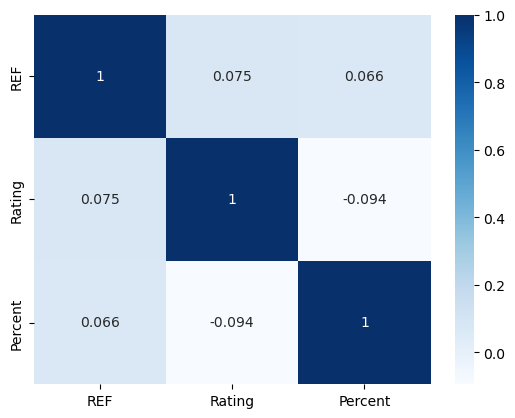

In [35]:
sns.heatmap(train.select_dtypes(['int','float']).corr(), cmap = "Blues", annot= True);

In [36]:
import association_metrics as am

In [37]:
XC = train.apply(lambda x: x.astype("category") if x.dtype=='object' else x)

In [38]:
cramersv=am.CramersV(XC)

In [39]:
cramersv.fit()

,Company,Specific Bean Origin,Review,Cocoa Percent,Company Location,Bean Type,Broad Bean Origin
Company,1.000000,0.653869,0.831088,0.593821,0.999680,0.588411,0.628460
Specific Bean Origin,0.653869,1.000000,0.758086,0.744575,0.738834,0.717287,0.920159
Review,0.831088,0.758086,1.000000,0.113762,0.420721,0.357475,0.339752
Cocoa Percent,0.593821,0.744575,0.113762,1.000000,0.251388,0.160958,0.224773
Company Location,0.999680,0.738834,0.420721,0.251388,1.000000,0.313797,0.365918
Bean Type,0.588411,0.717287,0.357475,0.160958,0.313797,1.000000,0.298870
Broad Bean Origin,0.628460,0.920159,0.339752,0.224773,0.365918,0.298870,1.000000


In [40]:
X = train.drop('Rating', axis=1) # Выделяем матрицу объект-признак и вектор с целевой переменной
y = train['Rating']

## 4) Выбор модели

In [41]:
categorical_columns = X.select_dtypes('object').columns

In [42]:
cat_features_ = []
for i in list(X.select_dtypes('object').columns):
    cat_features_.append(X.columns.get_loc(i))

In [43]:
p1 = Pipeline([
    ('encoder_',TargetEncoder(cols=categorical_columns, smoothing=1)), 
    ('features', PolynomialFeatures()),
    ('scaler_', StandardScaler()),
    ('model_', LinearRegression())
])

p2 = Pipeline([
    ('encoder_',TargetEncoder(cols=categorical_columns)),
    ('scaler_', StandardScaler()),
    ('features', PolynomialFeatures()),
    ('model_', GradientBoostingRegressor(verbose=0,random_state=RANDOM_STATE))
])

p3 = Pipeline([
    ('model_', CatBoostRegressor(cat_features=cat_features_,verbose=0,random_state=RANDOM_STATE)) 
])

p4 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=categorical_columns)),
    ('scaler_', MinMaxScaler()),
    ('features', PolynomialFeatures()),
    ('model_', AdaBoostRegressor(random_state=RANDOM_STATE))
    ])


p5 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=categorical_columns)),
    ('scaler_', StandardScaler()),
    ('features', PolynomialFeatures()),
    ('model_', RandomForestRegressor(random_state=RANDOM_STATE))
    ])


p6 = Pipeline([
    ('encoder_', TargetEncoder(cols=categorical_columns)),
    ('model_', XGBRegressor(random_state=RANDOM_STATE))
])


In [44]:
model= ['LinearRegression','GradientBoostingRegressor','CatBoostRegressor','AdaBoostRegressor','GradientBoostingRegressor','RandomForestRegressor','XGBRegressor']

In [45]:
%%time
for i, p in enumerate([p1, p2, p3, p4, p5, p6]):
    print(i,'Mодель:',model[i], 'r2_score',np.mean(cross_val_score(p,X,y,cv=5, scoring='r2')))

0 Mодель: LinearRegression r2_score 0.047817391800808705
1 Mодель: GradientBoostingRegressor r2_score 0.043477660931472095
2 Mодель: CatBoostRegressor r2_score 0.18239197246087951
3 Mодель: AdaBoostRegressor r2_score -0.020323828536030496
4 Mодель: GradientBoostingRegressor r2_score -8.407331566884224e-05
5 Mодель: RandomForestRegressor r2_score -0.03101754329669897
CPU times: total: 5min 17s
Wall time: 3min 16s


### Модель: CatBoostRegressor показад лучший результат r2_score 0.1824

## 5) Отбор признаков

In [48]:
cat_features_pre = []
for i in list(X.select_dtypes('object').columns):
    cat_features_pre.append(X.columns.get_loc(i))

In [49]:
model_pred = CatBoostRegressor(cat_features=cat_features_pre,verbose=0,random_state=RANDOM_STATE).fit(X, y)

In [54]:
pd.Series(model_pred.feature_importances_, index =X.columns).sort_values(ascending = False)# важность признаков

Company                 22.227712
Broad Bean Origin       12.218366
Company Location        11.509807
Percent                 10.520945
Review                   9.700353
REF                      9.157375
Bean Type                8.934801
Specific Bean Origin     8.884931
Cocoa Percent            6.845711
dtype: float64

In [98]:
from itertools import combinations

In [99]:
list_predict = []

In [100]:
otbor_priznakov = {}

In [101]:
for n in range(3,6):
       list_predict.append([i for i in combinations(np.arange(6),n)])

In [102]:
for n in range(len(list_predict)):
    for m in range(len(list_predict[n])):
        cat_features_pre = []
        for i in list(X.iloc[:,list(list_predict[n][m])].select_dtypes('object').columns):
            cat_features_pre.append(X.iloc[:,list(list_predict[n][m])].columns.get_loc(i))
        mean_cross = np.mean(cross_val_score(CatBoostRegressor(cat_features=cat_features_pre,verbose=0,random_state=RANDOM_STATE),X.iloc[:,list(list_predict[n][m])],y,cv=3, scoring='r2'))
        otbor_priznakov[list_predict[n][m]]=mean_cross

In [103]:
otbor_priznakov# комбинация признаков

{(0, 1, 2): 0.09163107113943199,
 (0, 1, 3): 0.06522988802151071,
 (0, 1, 4): 0.056523230970967044,
 (0, 1, 5): 0.043432979103824564,
 (0, 2, 3): 0.10824555533244344,
 (0, 2, 4): 0.15414938760192334,
 (0, 2, 5): 0.1078416707690838,
 (0, 3, 4): 0.09664215129660547,
 (0, 3, 5): 0.08973652007425337,
 (0, 4, 5): 0.09678592774682115,
 (1, 2, 3): -0.02846977803599145,
 (1, 2, 4): 0.021733995404176865,
 (1, 2, 5): 0.031895466275106865,
 (1, 3, 4): -0.08153503865583163,
 (1, 3, 5): -0.04941342959808862,
 (1, 4, 5): -0.06341148485090116,
 (2, 3, 4): 0.038220389861532124,
 (2, 3, 5): 0.044505748348879215,
 (2, 4, 5): 0.07070755342592187,
 (3, 4, 5): 0.027818387285204433,
 (0, 1, 2, 3): 0.0938488132374714,
 (0, 1, 2, 4): 0.12250411711583915,
 (0, 1, 2, 5): 0.10045713034029576,
 (0, 1, 3, 4): 0.07798561935704944,
 (0, 1, 3, 5): 0.07077765170698225,
 (0, 1, 4, 5): 0.07151835763859567,
 (0, 2, 3, 4): 0.14261290704365073,
 (0, 2, 3, 5): 0.12233465327859779,
 (0, 2, 4, 5): 0.14096684510567828,
 (0, 3,

In [111]:
X.iloc[:,list((0, 2, 4))].head(3)

,Company,REF,Cocoa Percent
0,Willie's Cacao,457,Bitter
1,Beschle (Felchlin),508,Bitter
2,Dark Forest,1554,Bitter


(0, 2, 4): 0.15414938760192334 - самые важные признаки

## 6) Обучение модели CatBoostRegressor 

In [104]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [105]:
import optuna

In [106]:
def objective_lgbm (trial):
    model_cb = CatBoostRegressor(cat_features=cat_features_,iterations = trial.suggest_int("iterations", 600, 700),depth = trial.suggest_int("depth", 6, 12), 
                                 learning_rate = trial.suggest_float("learning_rate", 0.01, 0.05),verbose=0, random_state=RANDOM_STATE).fit(x_train, y_train)
    y_pred=model_cb.predict(x_val)
    return r2_score(y_val,y_pred)

In [107]:
%%time
study = optuna.create_study(direction="maximize")
study.optimize(objective_lgbm, n_trials=50)

[I 2024-05-09 17:30:36,938] A new study created in memory with name: no-name-470bfb7c-8540-41b3-a3a4-7ffb4221b76b
[I 2024-05-09 17:31:03,753] Trial 0 finished with value: 0.2041177635333169 and parameters: {'iterations': 615, 'depth': 7, 'learning_rate': 0.04319902862096747}. Best is trial 0 with value: 0.2041177635333169.
[I 2024-05-09 17:31:24,229] Trial 1 finished with value: 0.1952724879729416 and parameters: {'iterations': 602, 'depth': 6, 'learning_rate': 0.04901543726276679}. Best is trial 0 with value: 0.2041177635333169.
[I 2024-05-09 17:31:46,303] Trial 2 finished with value: 0.18383986568767952 and parameters: {'iterations': 643, 'depth': 6, 'learning_rate': 0.039924264665329084}. Best is trial 0 with value: 0.2041177635333169.
[I 2024-05-09 17:32:38,241] Trial 3 finished with value: 0.19984471757756161 and parameters: {'iterations': 617, 'depth': 10, 'learning_rate': 0.03006967382295448}. Best is trial 0 with value: 0.2041177635333169.
[I 2024-05-09 17:35:59,950] Trial 4 fi

CPU times: total: 3h 24min 58s
Wall time: 1h 11min 53s


In [108]:
params = study.best_params

In [109]:
params

{'iterations': 611, 'depth': 11, 'learning_rate': 0.02409663173767051}

In [110]:
study.best_value

0.21796166204505418

In [129]:
model_best = CatBoostRegressor(**params,cat_features=cat_features_,random_state=RANDOM_STATE)

In [130]:
model_best.fit(X, y)

0:	learn: 0.4448463	total: 109ms	remaining: 1m 6s
1:	learn: 0.4432174	total: 186ms	remaining: 56.6s
2:	learn: 0.4417941	total: 318ms	remaining: 1m 4s
3:	learn: 0.4400790	total: 429ms	remaining: 1m 5s
4:	learn: 0.4384068	total: 555ms	remaining: 1m 7s
5:	learn: 0.4367967	total: 686ms	remaining: 1m 9s
6:	learn: 0.4357911	total: 704ms	remaining: 1m
7:	learn: 0.4339382	total: 922ms	remaining: 1m 9s
8:	learn: 0.4319392	total: 1.08s	remaining: 1m 12s
9:	learn: 0.4302474	total: 1.23s	remaining: 1m 14s
10:	learn: 0.4288953	total: 1.36s	remaining: 1m 14s
11:	learn: 0.4281063	total: 1.38s	remaining: 1m 9s
12:	learn: 0.4266659	total: 1.5s	remaining: 1m 8s
13:	learn: 0.4250809	total: 1.63s	remaining: 1m 9s
14:	learn: 0.4240278	total: 1.8s	remaining: 1m 11s
15:	learn: 0.4224067	total: 1.9s	remaining: 1m 10s
16:	learn: 0.4210131	total: 2.03s	remaining: 1m 11s
17:	learn: 0.4195549	total: 2.16s	remaining: 1m 11s
18:	learn: 0.4181321	total: 2.34s	remaining: 1m 13s
19:	learn: 0.4159538	total: 2.48s	remai

## Обработка тестовых данных, предсказание на тестовых данных

In [131]:
test = pd.read_csv('chocolate_test_new.csv')

In [132]:
test.shape

(540, 8)

In [133]:
test['Bean Type'] = test['Bean Type'].astype("str")

In [134]:
test['Bean Type'] = test['Bean Type'].apply(lambda x: 'Missing' if len(x)<2 else x)

In [135]:
test['Broad Bean Origin'] = test['Broad Bean Origin'].astype("str")

In [136]:
test['Broad Bean Origin'] = test['Broad Bean Origin'].apply(lambda x: 'Missing' if len(x)<2 else x)

In [137]:
test['Specific Bean Origin'] = test['Specific Bean Origin'].apply(lambda x: x.split(',')[0])

In [138]:
test["Percent"] = test["Cocoa Percent"].map(lambda x:float(x.strip('%')) / 100)

In [139]:
test['Cocoa Percent'] = test['Cocoa Percent'].apply(lambda x: float(x[0:-1]))
test['Cocoa Percent'] = test['Cocoa Percent'].replace(np.arange(90, 100.5, 0.5), 'Ultra Dark')
test['Cocoa Percent'] = test['Cocoa Percent'].replace(np.arange(70, 90, 0.5), 'Bitter')
test['Cocoa Percent'] = test['Cocoa Percent'].replace(np.arange(53, 70, 0.5), 'Dark')
test['Cocoa Percent'] = test['Cocoa Percent'].replace(np.arange(0, 53, 0.5), 'Milk')

In [140]:
test.Review = test.Review.map({2006:'old_date',2007:'old_date',2008:'old_date',2009:'old_date',2010:'average_date',2011:'average_date',2012:'average_date',2013:'average_date',2014:'new_date',2015:'new_date',2016:'new_date',2017:'new_date'})

In [141]:
test= test.reset_index()

In [142]:
columns_to_split = ['Company Location','Broad Bean Origin', 'Bean Type']

corrections = {'Dom. Rep.':"Dominican Republic", 'Domin. Rep':"Dominican Republic",'Dom. Rep':"Dominican Republic", 'Dominican Rep.':"Dominican Republic", 'D.R.':"Dominican Republic", 'DR': "Dominican Republic",'C.S.':'Central America', 'C. Am.':"Central America", "Ven.":'Venezuela','Venez':"Venezula", "Mex":"Mexico", 'Ven':"Venezula",'Ecuad.':'Ecuador','Trinidad-Tobago':'Trinidad,Tobago', 
 'Mad.':'Madagascar','Mad':'Madagascar','Venezuela/ Ghana':'Venezuela,Ghana','Peru(SMartin' 'Pangoa' 'nacional)':'Peru','Central and S. America':'Central America, South America', 'Carribean(DR/Jam/Tri)':'Carribean', 'Ghana & Madagascar':'Ghana,Madagascar','Ecu.':'Ecuador', 'Nic.':'Nicaragua','Madagascar & Ecuador':'Madagascar,Ecuador','Guat.':'Guatemala','Gre.':'Grenada','Haw.':'Hawaii', 'Sao Tome & Principe':'Sao Tome,Principe'}

for column in columns_to_split:
    test[column] = test[column].replace(corrections)
    test[column] = test[column].str.split(',')
    test = test.explode(column)
    test[column] = test[column].str.strip()
    test[column] = test[column].replace(corrections)

In [143]:
pred_Broad_Bean = model_predict_Broad_Bean.predict(test[test['Broad Bean Origin']=='Missing'][['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
       'Company Location', 'Bean Type','Percent']])

In [144]:
test.loc[test['Broad Bean Origin']=='Missing', 'Broad Bean Origin'] = pred_Broad_Bean

In [145]:
pred_BeanType = model_predict_BeanType.predict(test[test['Bean Type']=='Missing'][['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
       'Company Location', 'Broad Bean Origin','Percent']])

In [146]:
test.loc[test['Bean Type']=='Missing', 'Bean Type'] = pred_BeanType

In [147]:
pred_full = model_best.predict(test[X.columns])

In [148]:
test['Rating']=pred_full

In [149]:
test=test.rename(columns={'index':'id'})

In [150]:
test_kaggle= test.groupby('id',as_index=False)[['Rating']].mean()

In [151]:
test_kaggle.Rating = round(test_kaggle.Rating,2)

In [152]:
test_kaggle.to_csv("baseline_submission.csv", index=False)